# E1. Localization

### Define all the imports
Import all the dependencies required to launch the notebook

In [1]:
# Import main dependencies
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Change to main repo folder for the imports
_, dir = os.path.split(os.getcwd())
if dir == 'notebooks': 
    os.chdir('..')
    sys.path.append(os.getcwd())
# Ignore warnings from pandas
pd.set_option('mode.chained_assignment', None)

In [3]:
# Import methods from our local library
from src.localization.PF import ParticleFilter
from src.localization.EKF import ExtendedKalmanFilter

### Set dataset

In [27]:
# Define the dataset to be used for the following tests. 
dataset = "data/MRCLAM_Dataset4" # Dataset
end_frame = 100 # Extension of the dataset
robot = 'Robot5' # Robot

### T1. Review EKF localization
Review the ExtendedKalmanFilter() method, execute the EKF localization of the next code block, and answer the questions below:

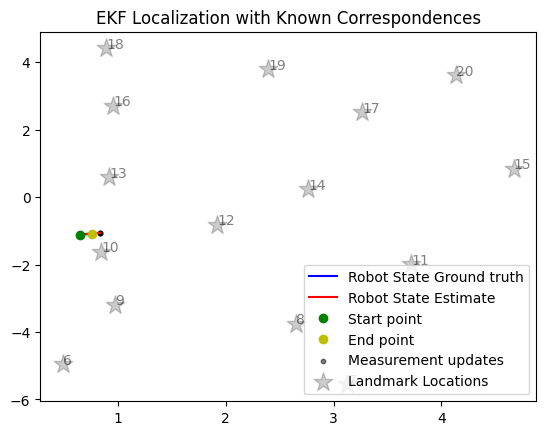

In [28]:
# Build Extended Kalman Filter object
R = np.diagflat(np.array([1.0, 1.0, 10.0]))** 2
Q = np.diagflat(np.array([300, 300, 1e16]))** 2
ekf = ExtendedKalmanFilter(dataset, robot, end_frame, R, Q)

**T11** The EKF localisation algorithm iteratively executes the functions motion_update() and measurement_update() to propagate the robot's state estimate. Could you specify, respectively for each of the two functions, when they are called and what their purpose is?

(Answer here max 150 words)
Look at the base class, and how it works

**T12** The ExtendedKalmanFilter() method inputs the R and Q matrices. Could you describe what are they used for and how they affect to the resulting localization estimation?

(Answer here max 150 words)


### T2. Review PF localization
Review the ParticleFilter() method, execute the PF localization of the next code block, and answer the questions below:

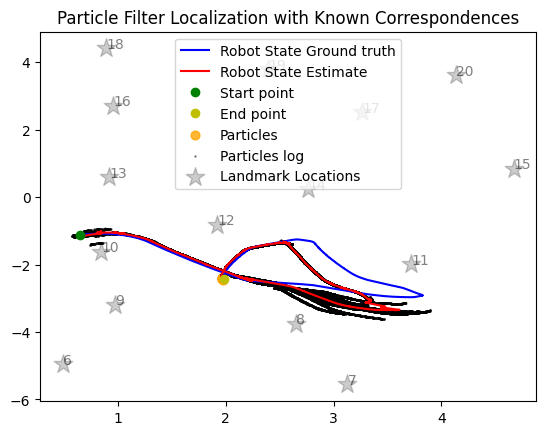

In [6]:
# Build Particle Filter object
num_particles = 10 #40-50 are okay!!
motion_noise = np.array([0.1, 0.1, 0.1, 0.2, 0.2]) # Motion model noise [noise_x, noise_y, noise_theta, noise_v, noise_w]
measurement_noise = np.array([0.1, 0.1]) # Measurement model noise (in meters / rad) [noise_range, noise_bearing]
pf = ParticleFilter(dataset, robot, end_frame, num_particles, motion_noise, measurement_noise, plot = True)

**T2.1** The PF localisation algorithm iteratively executes the functions motion_update(), measurement_update(), importance_sampling() and state_update(). Could you specify, the objective of each of the functions?

(Answer here max 150 words)

**T2.1** The ParticleFilter() method inputs three different configuration parameters: num_particles, motion_noise, measurement_noise. Could you describe what are they used for and how they affect to the resulting localization estimation?

(Answer here max 150 words)

### T3. Benchmark
Compare the EKF and the PF algorithms using diferent configurations for each algorithm and different datasets.
For the comparison use the error metrics introducced in previous lab sessions; the normalized accumulated error, the maximum error, and the final position error.

The objective of this task is to be able to determine the localization algorithm and configuration that provides the best performance. In order to decide which model and configuration works best follow the next steps:
1. Extract the error metrics for each dataset and model configuaration.
2. Represent the results in different types of plots (for instance catplot or correlation matrix).
3. Analyze the results and extract conclussions.


#### Extract error metrics

In [29]:
def normalized_path_error(position):
    d_gt_dis = []
    x_gt = position["x_gt"].tolist()
    y_gt = position["y_gt"].tolist()
    for i in range(len(x_gt) - 1):
        path_error = np.sqrt(np.power(x_gt[i] - x_gt[i+1], 2) + np.power(y_gt[i] - y_gt[i+1], 2))
        d_gt_dis.append(path_error)

    x_state = position["x"].tolist()
    y_state = position["y"].tolist()
        
    err_list = []
    weighted_err_list = []
    for i in range(1, len(x_gt)):
        path_error = np.sqrt(np.power(x_gt[i] - x_state[i], 2) + np.power(y_gt[i] - y_state[i], 2))
        err_list.append(path_error)
        weighted_err_list.append(path_error * d_gt_dis[i-1])
    e_path = np.sum(weighted_err_list) / np.sum(d_gt_dis)
    e_max = np.max(err_list)
    e_end = err_list[-1]
    return e_path, e_max, e_end

In [7]:
def normalized_path_error_optim(position_df):
    position = position_df.copy()
    position['x_delta'] = position["x_gt"].diff()
    position["y_delta"] = position["y_gt"].diff()
    position['x_delta'][0] = 0
    position['y_delta'][0] = 0
    position["weights"] = np.sqrt(position['x_delta']**2 + position["y_delta"]**2)
    position["path_error"] = np.sqrt(np.power(position["x_gt"] - position["x"], 2) + np.power(position["y_gt"] - position["y"], 2))
    position["e_path"] = (position["path_error"] * position["weights"]) / position["weights"].sum()

    e_path = position["e_path"].sum()
    e_max = np.max(position["path_error"])
    e_end = position["path_error"].iloc[-1]
    return e_path, e_max, e_end

In [30]:
ekf.build_dataframes()
# pf.build_dataframes()

In [10]:
joint_df = pd.DataFrame(pf.states).join(pf.gt, rsuffix = '_gt').dropna()

In [11]:
len(joint_df)

748

In [12]:
len(pf.states)

10001

In [14]:
# joint_df = pf.states
joint_df = pf.states.join(pf.gt, rsuffix = '_gt').dropna()#.drop_duplicates()
joint_df = joint_df.join(ekf.states, rsuffix = '_ekf').dropna()

In [31]:
joint_df = ekf.states.join(ekf.gt, rsuffix = '_gt').dropna()

In [32]:
e_path, e_max, e_end = normalized_path_error(joint_df)

In [33]:
e_path, e_max, e_end 

(0.07212181260616984, 0.0823890244383728, 0.08204160539548404)

In [19]:
e_path, e_max, e_end 

(0.13439542765311008, 0.27582547581938616, 0.1387607508132542)

In [15]:
e_path, e_max, e_end = normalized_path_error_optim(joint_df)

In [16]:
e_path, e_max, e_end

(0.1850627974736055, 0.5632373870132321, 0.0132458557253447)

In [22]:
models = {
    'BASE_EKF': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([1.0, 1.0, 10.0]))** 2,
        'Q': np.diagflat(np.array([300, 300, 1e16]))** 2
    },
    'EKF1': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([0.0, 1, 100]))** 2,
        'Q': np.diagflat(np.array([100, 50, 1e16]))** 2
    },
    'EKF2': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([2, 2, 200]))** 2,
        'Q': np.diagflat(np.array([5000, 5000, 0.1]))** 2
    },
    'EKF3': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([.001, .1, 1000]))** 2,
        'Q': np.diagflat(np.array([1000, 1000, 1e20]))** 2
    }, 
    'BASE_PF': {
        'type' : 'PF',
        'description': 'base',
        'motion_noise': np.array([0.1, 0.1, 0.1, 0.2, 0.2]),
        'measurement_noise': np.array([0.1, 0.1])
    },
    'PF1': {
        'type' : 'PF',
        'description': 'lower motion noise',
        'motion_noise': np.array([.001, .001, 0.001, 0.002, 0.002]),
        'measurement_noise': np.array([0.1, 0.1])
    },
    'PF2': {
        'type' : 'PF',
        'description': 'lower measurement noise',
        'motion_noise': np.array([0.1, 0.1, 0.1, 0.2, 0.2]),
        'measurement_noise': np.array([0.01, 0.01])
    },
    'PF3': {
        'type' : 'PF',
        'description': 'more angular motion noise',
        'motion_noise': np.array([.1, .1, 0.2, 0.1, 0.3]),
        'measurement_noise': np.array([0.001, 0.01])
    },
    'PF4': {
        'type' : 'PF',
        'description': 'balanced params',
        'motion_noise': np.array([0.01,0.01,0.1,0.1,0.2]),
        'measurement_noise': np.array([0.001, 0.01])
    },
}

In [17]:
datasets = ["data/MRCLAM_Dataset1",
            "data/MRCLAM_Dataset2",
            "data/MRCLAM_Dataset3",
            "data/MRCLAM_Dataset4"]

robots = ['Robot1',
          'Robot2',
          'Robot3',
          'Robot4']

models = {
    'BASE_EKF': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([1.0, 1.0, 10.0]))** 2,
        'Q': np.diagflat(np.array([300, 300, 1e16]))** 2
    },
    'EKF1': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([0.0, 1, 100]))** 2,
        'Q': np.diagflat(np.array([100, 50, 1e16]))** 2
    },
    'EKF2': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([2, 2, 200]))** 2,
        'Q': np.diagflat(np.array([5000, 5000, 0.1]))** 2
    },
    'EKF3': {
        'type' : 'EKF',
        'R': np.diagflat(np.array([.001, .1, 1000]))** 2,
        'Q': np.diagflat(np.array([1000, 1000, 1e20]))** 2
    }, 
    'BASE_PF': {
        'type' : 'PF',
        'motion_noise': np.array([0.1, 0.1, 0.1, 0.2, 0.2]),
        'measurement_noise': np.array([0.1, 0.1])
    },
    'PF1': {
        'type' : 'PF',
        'description': 'lower motion noise',
        'motion_noise': np.array([.001, .001, 0.001, 0.002, 0.002]),
        'measurement_noise': np.array([0.1, 0.1])
    },
    'PF2': {
        'type' : 'PF',
        'description': 'lower measurement noise',
        'motion_noise': np.array([0.1, 0.1, 0.1, 0.2, 0.2]),
        'measurement_noise': np.array([0.01, 0.01])
    },
    'PF3': {
        'type' : 'PF',
        'description': 'more angular motion noise',
        'motion_noise': np.array([.1, .1, 0.2, 0.1, 0.3]),
        'measurement_noise': np.array([0.001, 0.01])
    },
    'PF4': {
        'type' : 'PF',
        'description': 'balanced params',
        'motion_noise': np.array([0.01,0.01,0.1,0.1,0.2]),
        'measurement_noise': np.array([0.001, 0.01])
    },
}

errors = pd.DataFrame(columns=['dataset','robot', 'type', 'model_name','acc?error','max_error','final_error','time'])
experiment_window = 100
md = ''
t = ''

for ds in datasets:
    for rob in robots:
        for k, v in models.items():
            st = None
            md = k
            t = v['type']
            tic = time.perf_counter()
            if v['type'] == 'EKF':
                st = ExtendedKalmanFilter(ds, rob, experiment_window, v['R'], v['Q'], plot = False)
            else:
                # Build Particle Filter object
                num_particles = 10
                st = ParticleFilter(ds, rob, experiment_window, num_particles, v['motion_noise'], v['measurement_noise'], False)
            toc = time.perf_counter()
            st.build_dataframes()
            joint_df = st.states.join(st.gt, rsuffix = '_gt').dropna()
            e_path, e_max, e_end = normalized_path_error_optim(joint_df)
            errors.loc[-1] = [ds, rob, t, md, e_path, e_max, e_end, toc-tic]
            errors.index = errors.index + 1  # shifting index
            errors = errors.sort_index()

#### Represent metrics
For instance you could use the catplot of the seaborn library. Feel free to use another informative plot.

In [36]:
errors[['robot' == 'Robot5']]

ValueError: Item wrong length 1 instead of 144.

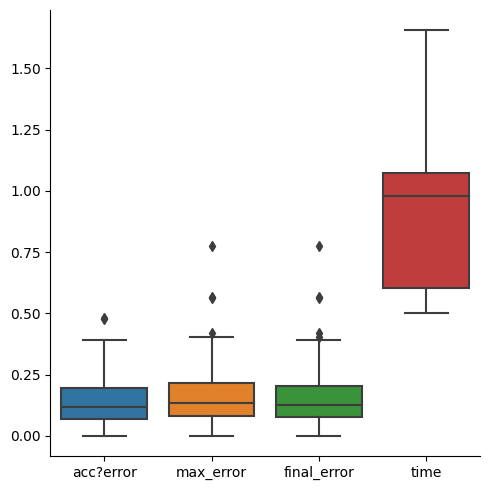

In [32]:
# Represent metrics for all experiments
sns.catplot(errors[errors['type']=='PF'], kind='box')

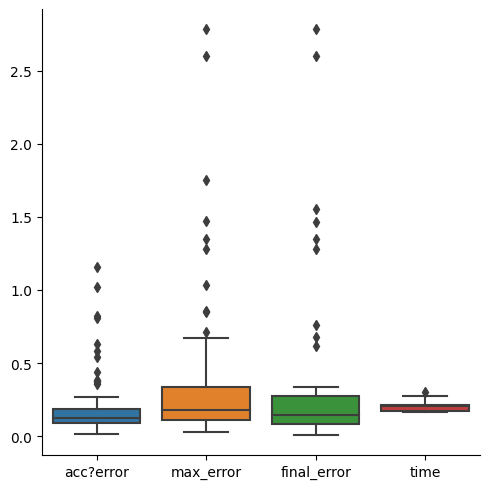

In [35]:
sns.catplot(errors[errors['type']=='EKF'], kind='box')

#### Analize metrics
**T3.1** Analize the representations, and extract some conclusions regarding the performance of each of the model configurations used. Which would be the best suited method for offline execution? Why?


(Answer here max 300 words)

**T3.2** Which would be the best suited method for online execution? Try to add the computation time as an extra metric for the assessment.

(Answer here max 150 words)

**T3.3** BONUS. How would you modify the PF filter to allow filter initialization without prior state belief?

(Answer here max 150 words)

### Delivery
Download the file in Notebook and Markdown formats to be uploaded in the Aula Digital.

To export the files go to File>Download as>Notebook and File>Download as>Markdown.

Save the files as **E1_name_surname.ipynb** and **E1_name_surname.md**

Compress files and figures in the same directory with the name **E1_name_surname.zip**